# **Annotated Diffusion Model Tutorial for 1D Data Generation**

In this notebook, we will build a denoising diffusion probabilistic model (DDPM) to generate a 1D data distribution. Diffusion models have emerged as powerful generative models by gradually adding noise to data (the forward process) and then learning to reverse this process (the reverse process) to generate new samples.

---


## **1. Introduction**

Diffusion models work by defining a forward noising process where, over a fixed number of time steps, Gaussian noise is gradually added to the data. This forward process is defined by a noise schedule (typically a sequence of beta values) such that after many steps the data becomes nearly pure noise. The model is then trained to learn the reverse process – to denoise or “denoise” the noisy data step-by-step and recover the original data distribution.

In this notebook we will:
- Generate a 1D dataset.
- Define the forward diffusion process.
- Build a simple neural network (an MLP) that predicts the added noise given a noisy input and a timestep embedding.
- Train the network using the mean squared error (MSE) loss.
- Sample from the model by running the reverse diffusion process.



---


## **2. Theoretical Background**

### **2.1 The Forward Process**

Given a data point $ x_0 $, the forward process gradually adds noise over $ T $ timesteps. At each timestep $ t $, we define:
$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon
$$
where:
- $\epsilon \sim \mathcal{N}(0, 1)$
- $ \bar{\alpha}_t = \prod_{s=1}^t \alpha_s $ with $ \alpha_s = 1 - \beta_s $
- The noise schedule $ \{ \beta_t \} $ is typically chosen to be linear.

### **2.2 The Reverse Process**

The reverse process is learned via a neural network that, given $ x_t $ and the timestep $ t $, predicts the noise $ \epsilon $ that was added. The training objective is to minimize:
$$
\mathcal{L} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$$

After training, we start with a sample $ x_T \sim \mathcal{N}(0, I) $ and iteratively remove noise using the learned model to generate samples from the data distribution.

---


## **3. Implementation**

Below we implement the complete pipeline in PyTorch.

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, moyal


### **3.1 Data Generation and Preprocessing**

Before diving into the diffusion process, we first generate our target 1D dataset. In our case, the data is produced by multiplying samples from a uniform distribution and a Moyal (Landau) distribution.


In [33]:
from scipy.stats import wasserstein_distance  # import wasserstein_distance
size = 1000000
np.random.seed(42)
random_pt = uniform(loc=2, scale=1).rvs(size=size, random_state=42)
random_smearing = moyal(loc=1, scale=0.2).rvs(size=size, random_state=42)
smeared_pt = np.multiply(random_pt, random_smearing)

# Conversion in float32
data = smeared_pt.astype(np.float32)
data = data[:100000]


# Calcola l'indice centrale
mid = len(data) // 2

# Splitta la lista in due parti uguali
parte1 = data[:mid]
parte2 = data[mid:]

# Converte le liste in array numpy per operazioni vettoriali
a = np.array(parte1)
b = np.array(parte2)

# Calcola il Mean Absolute Error (MAE)
mae = np.mean(np.abs(a - b))

# Calcola il Mean Squared Error (MSE)
mse = np.mean((a - b)**2)

wd1 = wasserstein_distance(a, b)

print("MAE:", mae)
print("MSE:", mse)
print("WD:", wd1)

#reshape of the dataset
data = data.reshape(-1, 1)


MAE: 1.23583
MSE: 2.7732797
WD: 0.005231000243425313


This section generates 1 million samples using a uniform distribution and a Moyal distribution, then multiplies the two to form the target distribution. We reduce the dataset to $100k$ samples for training.


In [34]:
# Calcola l'indice centrale
mid = len(data) // 2

# Splitta la lista in due parti uguali
parte1 = data[:mid]
parte2 = data[mid:]

# Converte le liste in array numpy per operazioni vettoriali
a = np.array(parte1)
b = np.array(parte2)

# Calcola il Mean Absolute Error (MAE)
mae = np.mean(np.abs(a - b))

# Calcola il Mean Squared Error (MSE)
mse = np.mean((a - b)**2)

print("MAE:", mae)
print("MSE:", mse)

MAE: 1.23583
MSE: 2.7732797


### **3.2 Creating a pyTorch Dataset**
We now wrap our 1D data into a PyTorch `Dataset` so that we can easily load it using a `DataLoader` for batching during training.


In [35]:
class DistributionDataset(Dataset):
    def __init__(self, data_array):
        self.data = torch.from_numpy(data_array) 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = DistributionDataset(data)
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

The `DistributionDataset` class wraps our numpy array into a PyTorch dataset. We then create a `DataLoader` that shuffles and batches the data for training.


### **3.3 Defining the Diffusion Process Schedule**
Next, we define the forward diffusion process. We set up a schedule for the noise variance by defining a sequence of beta values, then compute corresponding alphas and their cumulative product, which will be used in the diffusion equations. 

In [36]:
# Number of timesteps for diffusion
T = 1000
beta_start = 1e-4
beta_end = 0.02
betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
betas = torch.tensor(betas)
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def get_index_from_list(vals, t, x_shape):
    # Given a tensor t (shape: [batch]) returns a tensor of shape (batch, 1)
    batch_size = t.shape[0]
    out = vals[t].reshape(batch_size, 1)
    return out.to(x_shape.device)

Here we create a linear schedule for beta values, compute the corresponding alphas (where $\alpha_t = 1 - \beta_t$), and calculate $\bar{\alpha_t}$, the cumulative product over time. These values will be used to add noise to the data and later for denoising.


### **3.4 Building the Neural Network Model**

The core of the DDPM is a neural network that predicts the noise added at each timestep. We build a simple MLP (*Multi-Layer Perceptron*). The network conditions on the noisy input $x_t$ and a sinusoidal timestep embedding.

In [37]:
def get_timestep_embedding(timesteps, embedding_dim):
    # Generate sinusoidal embeddings (like positional encodings in Transformers)
    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:
        emb = torch.cat([emb, torch.zeros(timesteps.size(0), 1)], dim=1)
    return emb

class DiffusionModel(nn.Module):
    def __init__(self, hidden_dim=8, time_emb_dim=32):
        super(DiffusionModel, self).__init__()
        # Process the timestep embedding with a small MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, hidden_dim),
            nn.ReLU()
        )
        # Main model: an MLP that takes concatenated [x, timestep_embedding]
        self.model = nn.Sequential(
            nn.Linear(1 + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.time_emb_dim = time_emb_dim

    def forward(self, x, t):
        # x: (batch, 1), t: (batch,) contains integer timesteps
        t_emb = get_timestep_embedding(t, self.time_emb_dim)  # (batch, time_emb_dim)
        t_emb = self.time_mlp(t_emb)  # (batch, hidden_dim)
        x_input = torch.cat([x, t_emb], dim=1)
        return self.model(x_input)  # Predict the noise component

We define a function `get_timestep_embedding` to produce sinusoidal embeddings for the timesteps. The `DiffusionModel` class processes these embeddings and concatenates them with the noisy input. The network then outputs a prediction for the noise added at that timestep.


In [38]:
@torch.no_grad()
def sample_ddpm(model, sample_size, T, betas, alphas, alpha_bars):
    model.eval()
    x = torch.randn(sample_size, 1).to(device)   # Start with pure Gaussian noise
    for t_inv in reversed(range(T)):
        t_tensor = torch.full((sample_size,), t_inv, device=device, dtype=torch.long)
        
        beta_t = betas[t_inv].to(device)
        alpha_t = alphas[t_inv].to(device)
        alpha_bar_t = alpha_bars[t_inv].to(device)
        
         # Predict the noise for current x using the model
        pred_noise = model(x, t_tensor)
        mean = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * pred_noise)
        # Add noise except at the final step
        if t_inv > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0
        sigma_t = torch.sqrt(beta_t)
        x = mean + sigma_t * noise
    return x

### **3.5 Training the Diffusion Model**

We train the network to predict the noise added to the original data. For each batch, we:
1. Sample a random timestep $t$.
2. Compute the corresponding noisy data $x_t$ using the forward process.
3. Use the model to predict the noise.
4. Compute the MSE loss between the true noise and the model's prediction, and update the model.

In [39]:
from scipy.stats import wasserstein_distance  # import wasserstein_distance
import time  # for timing measurements

# Variable to accumulate only the weight update time
total_weight_update_time = 0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiffusionModel(hidden_dim=8, time_emb_dim=8).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)
epochs = 100
losses = []
wasserstein_vals = [] 
mse_vals = []          # To store MSE values between distributions
mae_vals = []   
epoch_saved = 0
min_distance=1000
checkpoint_epochs=range(epochs+1)
for epoch in range(epochs):
    
    model.train()
    epoch_loss = 0.0
    start_update = time.perf_counter()
    for batch in dataloader:
        
        # batch: (batch_size, 1)
        batch = batch.to(device)
        batch_size = batch.shape[0]
        
        # Randomly sample a timestep for each example in the batch
        t = torch.randint(0, T, (batch_size,), device=device)
        alpha_bar_t = alpha_bars[t].reshape(batch_size, 1).to(device)
        sqrt_alpha_bar = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_t)
        
        # Sample noise and compute the noisy input x_t
        noise = torch.randn_like(batch)
        x_t = sqrt_alpha_bar * batch + sqrt_one_minus_alpha_bar * noise
        
        # Model predicts the noise from x_t
        pred_noise = model(x_t, t)
        
        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * batch_size
    epoch_loss /= len(dataset)
    losses.append(epoch_loss)
    end_update = time.perf_counter()
    total_weight_update_time += (end_update - start_update)
#-------------------------------
    model.eval()
    with torch.no_grad():
        #     # Generate 1000 fake samples from the current model
        fake_samples = sample_ddpm(model, 1000, T, betas, alphas, alpha_bars)
    fake_samples_np = fake_samples.cpu().numpy().flatten()
    # Select 1000 random real samples
    idx = np.random.choice(len(data), 1000, replace=False)
    real_samples_np = data[idx].flatten()
    
    # Compute Wasserstein distance
    wd = wasserstein_distance(real_samples_np, fake_samples_np)
    
    # Sort both sets for quantile comparison
    #fake_sorted = np.sort(fake_samples_np)
    #real_sorted = np.sort(real_samples_np)
    # Compute MSE and MAE between the sorted arrays
    #mse_metric = np.mean((fake_sorted - real_sorted) ** 2)
    #mae_metric = np.mean(np.abs(fake_sorted - real_sorted))
    mse_metric = np.mean((fake_samples_np - real_samples_np) ** 2)
    mae_metric = np.mean(np.abs(fake_samples_np - real_samples_np))
    wasserstein_vals.append(wd)
    mse_vals.append(mse_metric)
    mae_vals.append(mae_metric)

    if(wd<min_distance):
        min_distance=wd
        epoch_saved=epoch

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {epoch_loss:.6f}, Wasserstein Distance = {wd:.6f}")
    if epoch in checkpoint_epochs:
        checkpoint_path = f"Model/model_epoch_{epoch}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        #print(f"Checkpoint salvato: {checkpoint_path}")



Epoch 0: Loss = 0.959269, Wasserstein Distance = 67.674653
Epoch 10: Loss = 0.280953, Wasserstein Distance = 0.069782
Epoch 20: Loss = 0.285531, Wasserstein Distance = 0.071390
Epoch 30: Loss = 0.285894, Wasserstein Distance = 0.060897
Epoch 40: Loss = 0.282326, Wasserstein Distance = 0.080537
Epoch 50: Loss = 0.282158, Wasserstein Distance = 0.117945
Epoch 60: Loss = 0.282948, Wasserstein Distance = 0.034420
Epoch 70: Loss = 0.278296, Wasserstein Distance = 0.079334
Epoch 80: Loss = 0.281812, Wasserstein Distance = 0.095438
Epoch 90: Loss = 0.277495, Wasserstein Distance = 0.049258


In [40]:
print(f"Final value: Loss = {epoch_loss:.6f}, Wasserstein Distance = {wd:.6f}, MAE = {mae_metric:.6f}, MSE = {mse_metric:.6f}")

Final value: Loss = 0.283557, Wasserstein Distance = 0.096334, MAE = 1.242707, MSE = 2.964504


In [41]:
print(f"Training time: {total_weight_update_time:.2f}s for {epochs} epochs")

Training time: 21.18s for 100 epochs


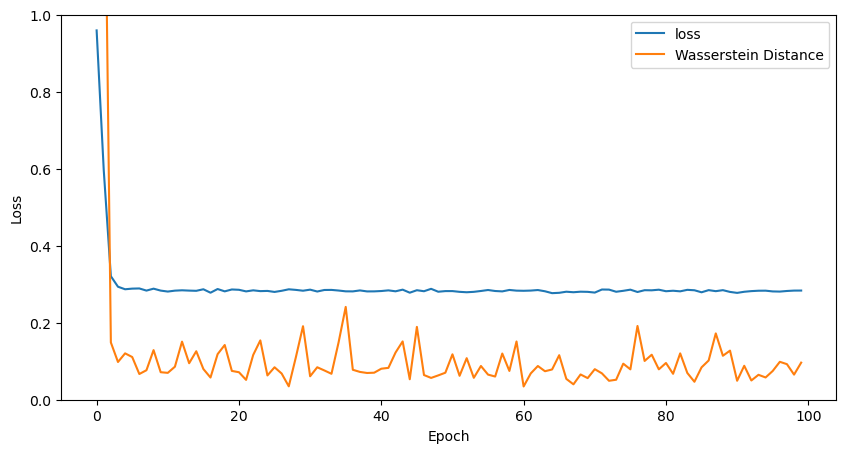

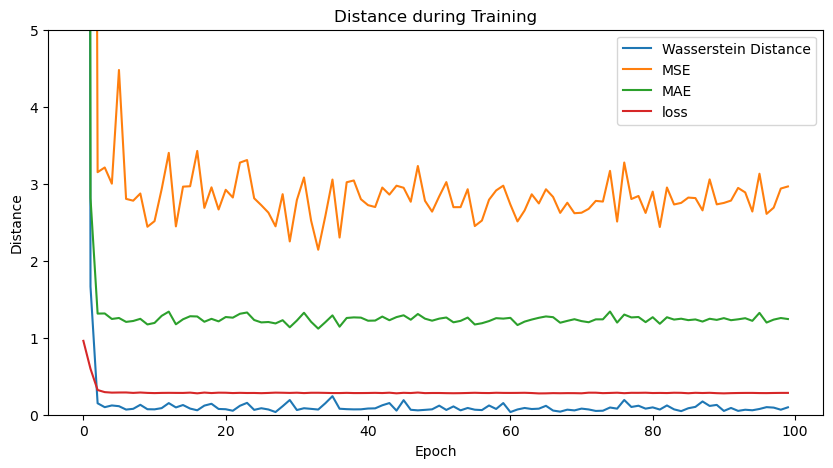

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label="loss")
plt.plot(wasserstein_vals, label="Wasserstein Distance")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(wasserstein_vals, label="Wasserstein Distance")
plt.plot(mse_vals, label="MSE")
plt.plot(mae_vals, label="MAE")
plt.plot(losses, label="loss")
plt.xlabel("Epoch")
plt.ylabel("Distance")
plt.title("Distance during Training")
plt.ylim(0,5)
plt.legend()
plt.show()

During training, for each batch we sample a random timestep $t$ and add noise to the data accordingly. The model then predicts the noise, and we compute the MSE loss between the predicted and true noise. The model parameters are updated via backpropagation using Adam.

### **3.6 Sampling from the Trained Model**

After training, we generate new samples by reversing the diffusion process. Starting from pure Gaussian noise, we iteratively denoise using our model. At each timestep $t$, we compute a mean for $x_{t-1}$ and add some noise if $t>0$.

In [43]:
sample_size = 100000
start=time.perf_counter()
x_samples = sample_ddpm(model, sample_size, T, betas, alphas, alpha_bars)
stop=time.perf_counter()
x_samples = x_samples.cpu().numpy()

GeneratorTimer=(stop-start)/sample_size

In [44]:
print(f"Time for generating a data: {GeneratorTimer:.2e}s")

Time for generating a data: 9.87e-05s


This function implements the reverse diffusion process. We start with a sample drawn from a standard Gaussian and then iterate backwards through timesteps, using the model to predict the noise at each step and gradually reconstruct $x_0$.

### **3.7 Visualising the Generated Distribution**

Finally, we compare the distribution of the generated samples with the original data distribution by plotting histograms.

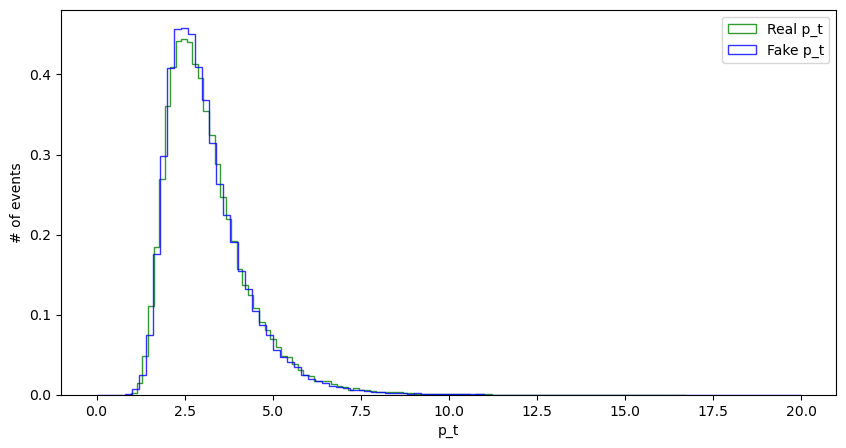

In [45]:
plt.figure(figsize=(10,5))
plt.hist(data, bins=100, density=True, alpha=0.8,histtype='step', color="green", label='Real p_t')
plt.hist(x_samples, bins=100, density=True, alpha=0.8,histtype='step', color="blue", label='Fake p_t', range=(0, 20))
plt.xlabel('p_t')
plt.ylabel('# of events')
plt.legend(loc='best')
plt.show()

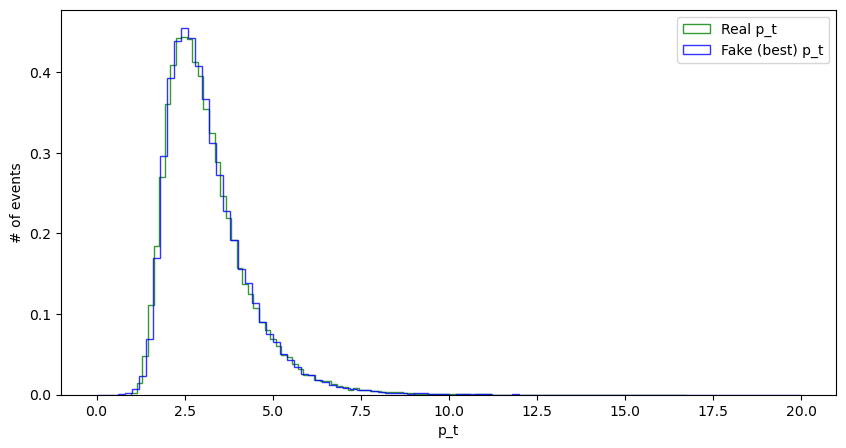

Final value: Wasserstein Distance = 0.034420, MAE = 1.258117, MSE = 2.729598


In [46]:
checkpoint_path = f"Model/model_epoch_{epoch_saved}.pth"
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model.eval()
sample_size = 100000
x_samples = sample_ddpm(model, sample_size, T, betas, alphas, alpha_bars)
x_samples = x_samples.cpu().numpy()
plt.figure(figsize=(10,5))
plt.hist(data, bins=100, density=True, alpha=0.8,histtype='step', color="green", label='Real p_t')
plt.hist(x_samples, bins=100, density=True, alpha=0.8,histtype='step', color="blue", label='Fake (best) p_t', range=(0, 20))
plt.xlabel('p_t')
plt.ylabel('# of events')
plt.legend(loc='best')
plt.show()

print(f"Final value: Wasserstein Distance = {wasserstein_vals[epoch_saved]:.6f}, MAE = {mae_vals[epoch_saved]:.6f}, MSE = { mse_vals[epoch_saved]:.6f}")

---

## **4. Conclusion**

In this notebook, we:
- Introduced the theoretical foundations of denoising diffusion probabilistic models.
- Built the forward diffusion process and a corresponding neural network to predict noise.
- Trained the network on 1D data and implemented the reverse process to sample new data points.
- Visualized the results to compare the generated distribution with the real data.

This tutorial demonstrates how DDPMs can be adapted from image generation to 1D data distribution modeling. Feel free to experiment with different network architectures, noise schedules, and training parameters to further refine the generated distribution.

Note that in respect to WGAN and NF, the DDPM is easier to train and more accurate in the data generation, but is less efficient becouse DDPM need the inverse diffusion (denoise) process!